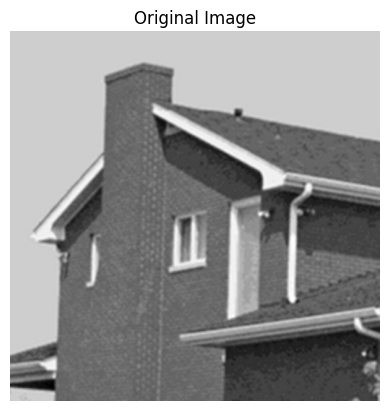

In [1]:
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Load and display the house.tif image
img = cv2.imread('house.tif', 0)  # Load as grayscale
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()



In [2]:
def edge_detector(image, sigma_value, kernel_size=None):
    # If kernel_size is not provided or is even, calculate the kernel size
    if kernel_size is None or kernel_size % 2 == 0:
        # Calculate the default kernel size based on sigma_value
        default_kernel_size = int(6 * sigma_value + 1) if sigma_value >= 1 else 5
        # Ensure the kernel size is odd
        kernel_size = default_kernel_size + (0 if default_kernel_size % 2 == 1 else 1)
    
    # Generate the grid of coordinates
    x_grid, y_grid = np.meshgrid(np.arange(-kernel_size//2+1, kernel_size//2+1), np.arange(-kernel_size//2+1, kernel_size//2+1))
    
    # Compute the normalization factor
    normalizer = -(1/(np.pi * sigma_value**4))
    
    # Compute the Gaussian kernel
    gaussian_kernel = normalizer * (1 - ((x_grid**2 + y_grid**2) / (2 * sigma_value**2))) * np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma_value**2))
    gaussian_kernel = gaussian_kernel / np.sum(np.abs(gaussian_kernel))
    
    # Apply the filter
    result_image = cv2.filter2D(image, -1, gaussian_kernel)
    
    return result_image

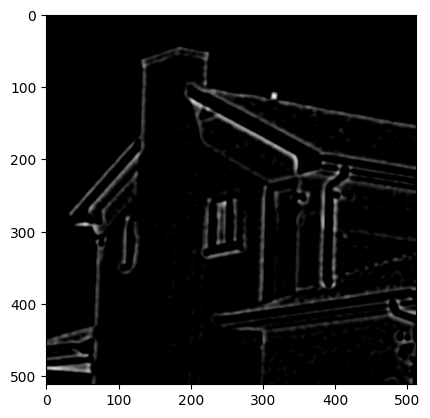

In [3]:
# Call the edge detection function with the desired sigma value
sigma_value = 3.0 # after testing various sigmas this was the most crisp vs 1
filtered_img = edge_detector(img, sigma_value)
# Convert the filtered image to uint8 format for display saves from future error
filtered_img_uint8 = cv2.convertScaleAbs(filtered_img)
# Display the filtered image using Matplotlib
plt.imshow(filtered_img_uint8, cmap="gray")
plt.show()

In [4]:
def manual_hough_transform(image, num_thetas=180, threshold=100):
    # Image dimensions
    height, width = image.shape

    # Maximum possible distance is the diagonal of the image
    max_distance = int(np.ceil(np.sqrt(height**2 + width**2)))
    rho_values = np.linspace(-max_distance, max_distance, 2 * max_distance)
    theta_values = np.deg2rad(np.linspace(-90, 90, num_thetas))

    # Initialize accumulator (2D array of theta vs rho)
    cos_theta = np.cos(theta_values)
    sin_theta = np.sin(theta_values)
    accumulator = np.zeros((2 * max_distance, num_thetas), dtype=int)

    # Find edge locations in the image
    edge_y_indices, edge_x_indices = np.nonzero(image)

    # Voting process
    for i in range(len(edge_x_indices)):
        x = edge_x_indices[i]
        y = edge_y_indices[i]
        for theta_idx in range(num_thetas):
            # Calculate rho: rho = x*cos(theta) + y*sin(theta)
            rho = int(round(x * cos_theta[theta_idx] + y * sin_theta[theta_idx])) + max_distance
            accumulator[rho, theta_idx] += 1

    # Identify peaks in the Hough space
    peak_indices = np.argwhere(accumulator > threshold)

    # Convert peak indices to actual rho and theta values
    rho_values = rho_values[peak_indices[:, 0]]
    theta_values = theta_values[peak_indices[:, 1]]

    return rho_values, theta_values, accumulator, theta_values, rho_values

In [5]:
def hough_linefitting(img):
    # Define the range of theta values
    thetas = np.deg2rad(np.arange(-90.0, 90.0))

    # Calculate image dimensions and diagonal length
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))

    # Create rho values from the diagonal length
    rhos = np.linspace(int(-diag_len), int(diag_len), int(diag_len * 2.0))

    # Compute Hough Transform
    accumulator, thetas, rhos = manual_hough_transform(img)

    return accumulator, thetas, rhos

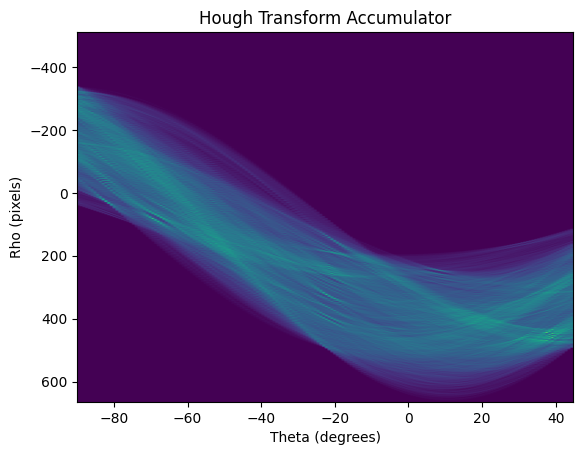

In [6]:
# Call the edge detection function to get the edge image
edges = edge_detector(img, sigma_value=1)

# Perform the Hough Transform
rho_values, theta_values, accumulator, _, _ = manual_hough_transform(edges, threshold=50)

# Display the Hough Transform Accumulator
plt.imshow(accumulator, aspect='auto', extent=[np.rad2deg(theta_values[0]), np.rad2deg(theta_values[-1]), rho_values[-1], rho_values[0]])
plt.title('Hough Transform Accumulator')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.show()

Number of lines detected: 48


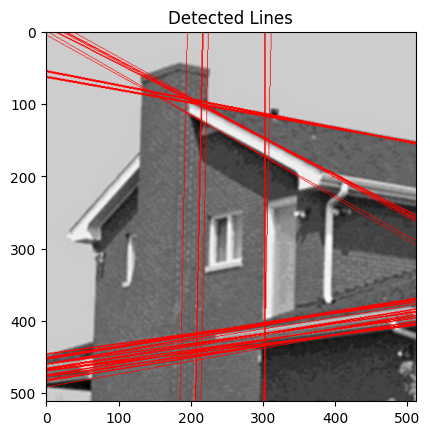

In [15]:
# Constants for line detection
ACCUMULATOR_THRESHOLD = 250
EXTENSION_LENGTH = 1000  # Extend the lines for better visualization

# Calculate the image diagonal length for rho range
image_diagonal = int(np.ceil(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))
theta_degrees = np.arange(-90.0, 90.0)  # Degree range for theta
theta_radians = np.deg2rad(theta_degrees)  # Convert degrees to radians

# Generate rhos based on the diagonal length of the image
rho_range = np.linspace(-image_diagonal, image_diagonal, 2 * image_diagonal)

# Finding lines above a defined threshold in the accumulator
indices_of_high_accumulation = np.where(accumulator > ACCUMULATOR_THRESHOLD)
strong_rhos = rho_range[indices_of_high_accumulation[0]]
strong_thetas = theta_radians[indices_of_high_accumulation[1]]
strong_line_parameters = np.vstack([strong_rhos, strong_thetas]).T

print("Number of lines detected:", strong_line_parameters.shape[0])

# Convert grayscale image to BGR to draw colored lines
color_image = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

def polar_to_cartesian(rho, theta):
    # Convert polar coordinates to Cartesian coordinates for line drawing.
    cosine_theta = np.cos(theta)
    sine_theta = np.sin(theta)
    x0 = cosine_theta * rho
    y0 = sine_theta * rho
    x1 = int(x0 + EXTENSION_LENGTH * (-sine_theta))
    y1 = int(y0 + EXTENSION_LENGTH * (cosine_theta))
    x2 = int(x0 - EXTENSION_LENGTH * (-sine_theta))
    y2 = int(y0 - EXTENSION_LENGTH * (cosine_theta))
    return (x1, y1), (x2, y2)

# Draw detected lines on the image
for rho, theta in strong_line_parameters:
    line_start, line_end = polar_to_cartesian(rho, theta)
    cv2.line(color_image, line_start, line_end, (0, 0, 255), 1)

# Display the image with detected lines
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines')
plt.show()

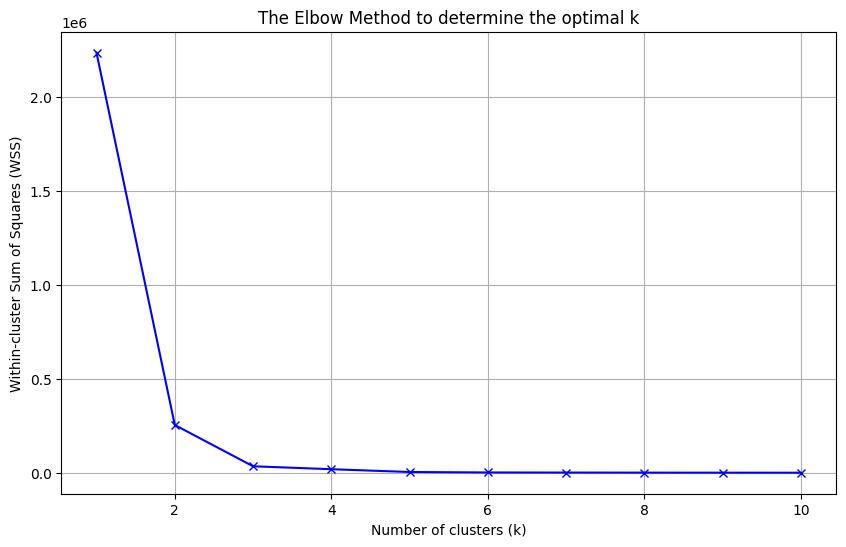

In [8]:
from sklearn.cluster import KMeans

def calculate_wss(points, k_max):
    wss = []
    k_range = range(1, k_max + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(points)
        wss.append(kmeans.inertia_)  # inertia_ is the WSS
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wss, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster Sum of Squares (WSS)')
    plt.title('The Elbow Method to determine the optimal k')
    plt.grid(True)
    plt.show()

# Assuming strong_line_parameters is defined from your Hough line detection
calculate_wss(strong_line_parameters, 10)

In [9]:
import random

def generate_random_points(line_start, line_end, num_samples=100):
    """ Generate random points along the line between two given points. """
    t_values = np.random.uniform(low=0, high=1, size=num_samples)
    points = line_start + np.outer(t_values, (line_end - line_start))
    return points.reshape(-1, 2)

def calculate_distance(slope, intercept, point):
    """ Calculate perpendicular distance of a point from a line given by slope and intercept. """
    return abs(slope * point[0] - point[1] + intercept) / np.sqrt(slope**2 + 1)

def slope_intercept(point1, point2):
    """ Calculate slope and intercept from two points. """
    x1, y1 = point1
    x2, y2 = point2
    if x2 != x1:
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
    else:
        slope = np.inf  # Infinite slope -> vertical line
        intercept = x1  # 'intercept' represents x = constant
    return slope, intercept

def custom_ransac(data, num_iterations=50, threshold=1.0):
    """ RANSAC algorithm to find the best fitting line model in the data. """
    best_slope = best_intercept = None
    max_inliers = []

    for _ in range(num_iterations):
        # Convert data to list if it's not already
        data_list = list(map(tuple, data))  # Ensuring data is a list of tuples
        # Randomly pick 2 distinct points
        sample_points = random.sample(data_list, 2)
        slope, intercept = slope_intercept(sample_points[0], sample_points[1])
        inliers = []

        # Calculate number of inliers
        for point in data_list:
            if calculate_distance(slope, intercept, point) < threshold:
                inliers.append(point)

        # Update the best model if current one has more inliers
        if len(inliers) > len(max_inliers):
            max_inliers = inliers
            best_slope = slope
            best_intercept = intercept

    return best_slope, best_intercept, max_inliers

cluster_labels = np.array([1, 2, 3])  # Cluster labels

In [13]:
# Define a dictionary to store sampled points from each cluster
clustered_line_samples = {}

# Loop over each unique cluster identified by the KMeans algorithm
for cluster_id in np.unique(cluster_labels):
    # Initialize a list to store sampled points for the current cluster
    sampled_points = []
    
    # Loop over all line parameters
    for index, cluster in enumerate(cluster_labels):
        # Check if the current line belongs to the current cluster
        if cluster == cluster_id:
            rho, theta = strong_rhos[index], strong_thetas[index]
            # Convert polar coordinates to Cartesian endpoints
            line_start, line_end = polar_to_cartesian(rho, theta)
            
            # Ensure line_start and line_end are numpy arrays for arithmetic operations
            line_start = np.array(line_start)
            line_end = np.array(line_end)

            # Generate two random points along the line
            # Use numpy to vectorize the generation of random points
            random_factors = np.random.uniform(low=0, high=1, size=2)
            sampled_points_along_line = line_start + np.outer(random_factors, (line_end - line_start))
            
            # Extend the list of sampled points for this cluster
            sampled_points.extend(sampled_points_along_line)
    
    # Convert the list of sampled points into a numpy array and store it in the dictionary
    clustered_line_samples[cluster_id] = np.vstack(sampled_points)

Cluster 1: Number of inliers: 100
Cluster 2: Number of inliers: 100
Cluster 3: Number of inliers: 100


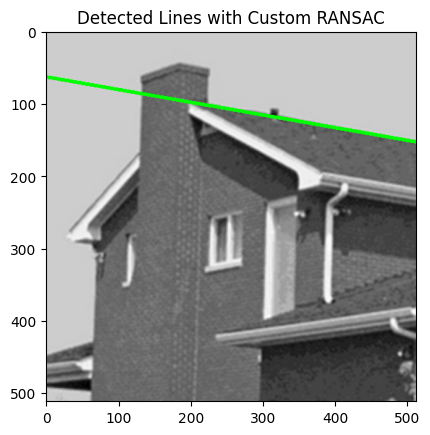

In [14]:

# Dictionary to store random points along detected lines for each cluster
clustered_points = {}
for cluster_index in np.unique(cluster_labels):
    sampled_points = []
    for index in np.where(cluster_labels == cluster_index)[0]:
        rho, theta = strong_line_parameters[index]
        line_start, line_end = polar_to_cartesian(rho, theta)
        sampled_points.extend(generate_random_points(np.array(line_start), np.array(line_end)))
    clustered_points[cluster_index] = np.array(sampled_points)

# Run custom RANSAC on each cluster's points
fitted_lines = {}
for cluster_index, points in clustered_points.items():
    slope, intercept, inliers = custom_ransac(points)
    fitted_lines[cluster_index] = {'slope': slope, 'intercept': intercept, 'inliers': inliers}
    print(f"Cluster {cluster_index}: Number of inliers: {len(inliers)}")

# Draw lines on the original image
image_with_lines = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
for cluster_index, line_data in fitted_lines.items():
    if line_data['slope'] != np.inf:
        # Normal line case
        x_vals = np.array([0, image_with_lines.shape[1]])
        y_vals = line_data['slope'] * x_vals + line_data['intercept']
    else:
        # Vertical line case
        x_vals = np.array([line_data['intercept'], line_data['intercept']])
        y_vals = np.array([0, image_with_lines.shape[0]])

    pt1 = (int(x_vals[0]), int(y_vals[0]))
    pt2 = (int(x_vals[1]), int(y_vals[1]))
    cv2.line(image_with_lines, pt1, pt2, (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Detected Lines with Custom RANSAC')
plt.show()